In [1]:
import pandas as pd
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import requests

In [2]:
!git clone https://github.com/kkruglik/foodvision_project.git

Cloning into 'foodvision_project'...
remote: Enumerating objects: 619, done.
remote: Counting objects: 100% (619/619), done.
remote: Compressing objects: 100% (618/618), done.
remote: Total 619 (delta 1), reused 615 (delta 0), pack-reused 0
Receiving objects: 100% (619/619), 30.00 MiB | 23.13 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [23]:
import sys
sys.path.insert(0,'/content/foodvision_project')

from engine import train

In [3]:
import zipfile
from typing import Dict, List, Tuple

In [22]:
from torch import nn
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
import os

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.
    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

In [8]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path


[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [9]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

In [10]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [11]:
for param in effnetb2.parameters():
    param.requires_grad = False

In [12]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [13]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(1408, 3)
)

In [14]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=1408, out_features=3, bias=True)
)

In [15]:
# # # Print EffNetB2 model summary (uncomment for full output) 
# summary(effnetb2, 
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [16]:
NUM_WORKERS = 2
def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.
  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.
  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.
  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [17]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [18]:
optimizer = torch.optim.Adam(effnetb2.parameters(), lr=1e-3)
loss = torch.nn.CrossEntropyLoss()

In [27]:
effnetb2_results = train(model=effnetb2,
                        train_dataloader=train_dataloader_effnetb2,
                        test_dataloader=test_dataloader_effnetb2,
                        epochs=10,
                        optimizer=optimizer,
                        loss_fn=loss,
                        device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6800 | train_acc: 0.8229 | test_loss: 0.5667 | test_acc: 0.9318
Epoch: 2 | train_loss: 0.5683 | train_acc: 0.8729 | test_loss: 0.4762 | test_acc: 0.9688
Epoch: 3 | train_loss: 0.4681 | train_acc: 0.9083 | test_loss: 0.4143 | test_acc: 0.9381
Epoch: 4 | train_loss: 0.3904 | train_acc: 0.9104 | test_loss: 0.3700 | test_acc: 0.9625
Epoch: 5 | train_loss: 0.4189 | train_acc: 0.8896 | test_loss: 0.3454 | test_acc: 0.9625
Epoch: 6 | train_loss: 0.4422 | train_acc: 0.8667 | test_loss: 0.3272 | test_acc: 0.9381
Epoch: 7 | train_loss: 0.3098 | train_acc: 0.9313 | test_loss: 0.3181 | test_acc: 0.9625
Epoch: 8 | train_loss: 0.2999 | train_acc: 0.9417 | test_loss: 0.2973 | test_acc: 0.9688
Epoch: 9 | train_loss: 0.3073 | train_acc: 0.9333 | test_loss: 0.2760 | test_acc: 0.9722
Epoch: 10 | train_loss: 0.3316 | train_acc: 0.9000 | test_loss: 0.2675 | test_acc: 0.9563


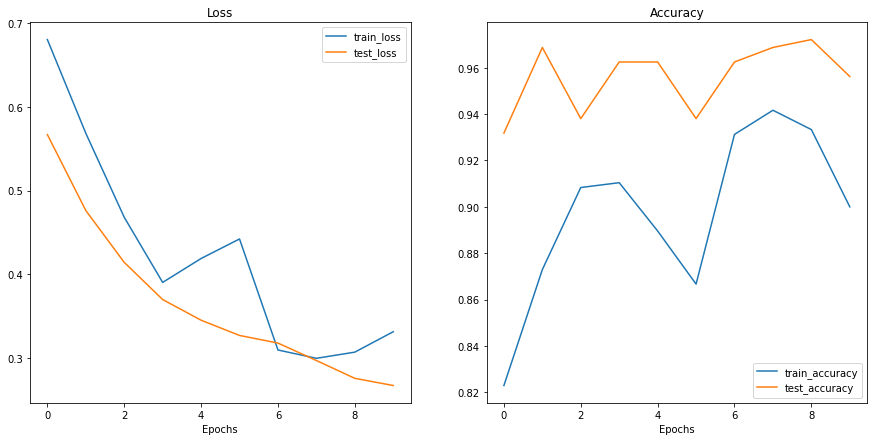

In [28]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [34]:
!mkdir /content/models

PosixPath('/content/models')

In [40]:
torch.save(effnetb2.state_dict(), '/content/models/eff_net.pth')